In [2]:
import os, folium, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imageio.v3 as iio
import geopandas as gpd
from IPython.display import Image, display
import tensorflow as tf
%matplotlib inline

In [3]:
from tensorflow.keras import layers, callbacks, backend, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

In [4]:
labels= gpd.read_file('labels.geojson')
labels.head(2)

,id,Latitude,Longitude,Type,Source,Image_Folder,geometry
0,1,43.004434,-78.208900,Negative,Aeroplanes,train_images/43.00443446102501_-78.20890003579709,"POLYGON ((-78.20567 43.00681, -78.20567 43.002..."
1,6,42.033642,-97.719996,Negative,"White Spec (Seadoo, pivot irrigation, etc.)",train_images/42.03364226519898_-97.7199955063882,"POLYGON ((-97.71676 42.03605, -97.71676 42.031..."


In [5]:
labels_unique = labels[(labels.Type == 'Negative') | (labels.Type == 'CAFOs') | (labels.Type == 'WWTreatment')
           | (labels.Type == 'Landfills') | (labels.Type == 'RefineriesAndTerminals')
           | (labels.Type == 'ProcessingPlants') | (labels.Type == 'Mines')]

In [6]:
def build_model():
    i = layers.Input(shape=(720,720, 3), dtype = tf.float32)
    i1 = layers.Resizing(
        224,
        224,
        interpolation='bilinear',
        crop_to_aspect_ratio=False
    )(i)
    out = tf.keras.applications.EfficientNetB0(include_top=True,
                      weights='imagenet'
                      )(i1)
    out = layers.Dense(32, activation='relu')(out)
    out = layers.Dense(7, activation='sigmoid')(out)
    model = Model(inputs=i, outputs=out)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [8]:
from keras.preprocessing import image
dir_path=r"/root/code/dvictoria2/methane_source/"
datagen=image.ImageDataGenerator(rescale=1./255, validation_split = 0.9)

In [9]:
labels_unique

,id,Latitude,Longitude,Type,Source,Image_Folder,geometry
0,1,43.004434,-78.208900,Negative,Aeroplanes,train_images/43.00443446102501_-78.20890003579709,"POLYGON ((-78.20567 43.00681, -78.20567 43.002..."
1,6,42.033642,-97.719996,Negative,"White Spec (Seadoo, pivot irrigation, etc.)",train_images/42.03364226519898_-97.7199955063882,"POLYGON ((-97.71676 42.03605, -97.71676 42.031..."
2,9,34.495000,-97.118000,WWTreatment,HydroWASTE,train_images/34.495_-97.118,"POLYGON ((-97.11477 34.49768, -97.11477 34.492..."
3,12,38.381380,-75.401000,CAFOs,DataForCauseChallenge,train_images/38.38138_-75.401,"POLYGON ((-75.39777 38.38393, -75.39777 38.378..."
4,17,45.647973,-84.469159,RefineriesAndTerminals,EIA-HIFLD,train_images/45.647973_-84.469159,"POLYGON ((-84.46593 45.65024, -84.46593 45.645..."
...,...,...,...,...,...,...,...
14182,84941,35.852756,-101.538265,Negative,Windmills,train_images/35.85275555452138_-101.5382646083...,"POLYGON ((-101.53503 35.85539, -101.53503 35.8..."
14183,85008,47.186826,-122.436115,Negative,Roundabout,train_images/47.18682636726484_-122.4361145478...,"POLYGON ((-122.43288 47.18903, -122.43288 47.1..."
14184,85035,42.703517,-83.303270,Negative,Parking Lots,train_images/42.703517482995565_-83.3032698788...,"POLYGON ((-83.30004 42.70590, -83.30004 42.701..."
14185,85048,34.159700,-86.468760,CAFOs,DataForCauseChallenge,train_images/34.1597_-86.46876,"POLYGON ((-86.46553 34.16239, -86.46553 34.157..."


In [10]:
labels_unique.Image_Folder=labels_unique.Image_Folder+"/naip.png"

/root/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [11]:
train_generator=datagen.flow_from_dataframe(
    dataframe=labels_unique, directory=dir_path, 
    x_col="Image_Folder", y_col="Type", seed = 42,
    class_mode="categorical", target_size=(720,720), batch_size=128, subset = "training", color_mode='rgb')

Found 1413 validated image filenames belonging to 7 classes.


In [12]:
X_train, y_train = train_generator.next()

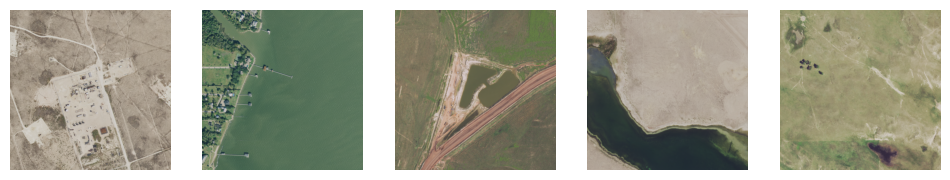

In [14]:
fig, axs = plt.subplots(1, 5, figsize=(12, 6))
for i in range(5):
    axs[i].imshow(X_train[i])
    axs[i].axis('off')

plt.show()

In [ ]:
y


array([[0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
 

In [ ]:
validation_generator = datagen.flow_from_dataframe(dataframe=labels_unique, directory=dir_path, 
    x_col="Image_Folder", y_col="Type", seed = 42,
    class_mode="categorical", target_size=(720,720), batch_size=128, subset = "validation", color_mode='rgb')

Found 7063 validated image filenames belonging to 7 classes.


In [ ]:
X_train.shape

(128, 720, 720, 3)

In [22]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

In [29]:
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import layers

def build_model():
    i = layers.Input(shape=(720, 720, 3), dtype=tf.float32)
    #i1 = layers.Resizing(224, 224, interpolation='bilinear', crop_to_aspect_ratio=False)(i)
    #i2 = layers.Rescaling(1./255)(i1)
    #d = layers.Conv2D(3, (1, 1))(i2)
    base= EfficientNetB0(include_top=False, weights='imagenet')(i)
    #base.trainable = False
    out = layers.Flatten()(base)
    out2 = layers.Dense(16, activation='relu')(out)
    out3 = layers.Dense(7, activation='sigmoid')(out2)
    model = Model(inputs=i, outputs=out3)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


In [31]:
backend.clear_session()
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 720, 720, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 flatten (Flatten)           (None, 619520)            0         
                                                                 
 dense (Dense)               (None, 16)                9912336   
                                                                 
 dense_1 (Dense)             (None, 7)                 119       
                                                                 
Total params: 13,962,026
Trainable params: 13,920,003
Non-trainable params: 42,023
_________________________________________________________________


In [32]:
cb = [callbacks.EarlyStopping(patience=5), callbacks.ReduceLROnPlateau(patience=3),callbacks.ModelCheckpoint('methane_V1.hdf5', monitor='loss',verbose=1, save_best_only=True)]
epochs = 50
# fits the model on batches with real-time data augmentation:
history =model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10, callbacks = cb)

/tmp/ipykernel_2197/2055356551.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history =model.fit_generator(generator=train_generator,


Epoch 1/10


2023-05-23 08:17:39.127852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-23 08:17:40.958050: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-23 08:17:40.958140: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-23 08:17:40.958286: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 51939 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-05-23 08:17:40.958309: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

: 

: 

In [16]:
X = []
for im_path in labels_unique.Image_Folder.values:
     X.append(iio.imread(f'{im_path}'))

In [17]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels_unique.Type.values.reshape(labels_unique.Type.values.shape[0], 1))
mlb.classes_
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size=0.1, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, train_size=0.02, stratify=y_rest)
def invert_ecoding(encoded_labels, categories):
    categories = ['[unk]']+categories
    return np.take(categories, np.argwhere(encoded_labels == 1.0)[:,1])
y_tra_orig = np.argwhere(y_train == 1.0)[:,1]
y_res_orig = np.argwhere(y_rest == 1.0)[:,1]
X_train=np.array(X_train)
X_val=np.array(X_val)

In [28]:
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import layers

def build_model():
    i = layers.Input(shape=(720, 720, 4), dtype=tf.float32)
    i1 = layers.Resizing(224, 224, interpolation='bilinear', crop_to_aspect_ratio=False)(i)
    i2 = layers.Rescaling(1./255)(i1)
    d = layers.Conv2D(3, (1, 1))(i2)
    base= EfficientNetB0(include_top=False, weights='imagenet')(d)
    #base.trainable = False
    out = layers.Flatten()(base)
    out2 = layers.Dense(16, activation='relu')(out)
    out3 = layers.Dense(7, activation='sigmoid')(out2)
    model = Model(inputs=i, outputs=out3)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


In [29]:
model=build_model()
cb = [callbacks.EarlyStopping(patience=5), callbacks.ReduceLROnPlateau(patience=3)]
epochs = 10
batch_size = 64

history = model.fit(X_train,
         y_train,
         epochs=epochs,
         batch_size=batch_size,
         callbacks=cb,
         validation_data=(X_val, y_val))


Epoch 1/10


2023-05-23 08:57:12.681163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-23 08:57:14.892488: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-23 08:57:14.892530: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-23 08:57:14.892550: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 51939 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-05-23 08:57:14.892570: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

23/23 [==============================] - ETA: 0s - loss: 0.5759 - accuracy: 0.5361

2023-05-23 08:58:11.605245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-23 08:58:12.146765: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-23 08:58:12.147000: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-23 08:58:12.147168: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 51939 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-05-23 08:58:12.147195: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

23/23 [==============================] - 65s 2s/step - loss: 0.5759 - accuracy: 0.5361 - val_loss: 0.5685 - val_accuracy: 0.4094 - lr: 0.0010
Epoch 2/10
23/23 [==============================] - 78s 3s/step - loss: 0.4971 - accuracy: 0.6381 - val_loss: 0.5558 - val_accuracy: 0.4094 - lr: 0.0010
Epoch 3/10
23/23 [==============================] - 73s 3s/step - loss: 0.4412 - accuracy: 0.6714 - val_loss: 1.0202 - val_accuracy: 0.4094 - lr: 0.0010
Epoch 4/10
23/23 [==============================] - 73s 3s/step - loss: 0.3966 - accuracy: 0.6848 - val_loss: 1.2613 - val_accuracy: 0.4094 - lr: 0.0010
Epoch 5/10
23/23 [==============================] - 73s 3s/step - loss: 0.3486 - accuracy: 0.7167 - val_loss: 0.8687 - val_accuracy: 0.4094 - lr: 0.0010
Epoch 6/10
23/23 [==============================] - 75s 3s/step - loss: 0.3074 - accuracy: 0.7904 - val_loss: 0.7670 - val_accuracy: 0.4094 - lr: 1.0000e-04
Epoch 7/10
23/23 [==============================] - 68s 3s/step - loss: 0.2881 - accuracy

In [30]:
y_pred = model.predict(X_test)
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
